##Посилання на візуалізацію в Tableau
https://public.tableau.com/views/RevenueEngagementMonitor/Dashboard1?:language=en-US&publish=yes&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link

In [ ]:
!pip install --upgrade google-cloud-bigquery


In [ ]:
from google.colab import auth
from google.cloud import bigquery
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import plotly as pt
import plotly.express as px
import plotly.graph_objects as go
from scipy import stats
from scipy.stats import normaltest, shapiro, spearmanr, kendalltau, mannwhitneyu

# Data extraction

In [ ]:
auth.authenticate_user()


In [ ]:
client = bigquery.Client(project="data-analytics-mate")


Формуємо в BigQuery єдину таблицю для аналізу на рівні сесія (і, за наявності, сесія+замовлення):
1) У CTE product_info об’єднуємо order і product, щоб підготувати довідник товарів, прив’язаний до ga_session_id (CTE використано для читабельності і оптимізації продуктивності).
2) Основою є таблиця session. Дані про акаунт і стан верифікації/підписки під’єднуємо через LEFT JOIN на account_session та account, щоб зберегти всі сесії, навіть без акаунта.
3) Товари під’єднуємо через LEFT JOIN product_info; це може збільшити кількість рядків (по товару в межах сесії), що зручно для подальших агрегувань на рівні товарів.
4) Для включення параметрів сесій, приєднуємо session_params як LEFT JOIN із вибірковим витягом потрібних стовпців.
5) Логічні поля (is_verified, is_subscribed) повертаємо у булевому форматі, з явною обробкою NULL для коректної інтерпретації.

In [ ]:
query = """
WITH
  product_info AS (
  SELECT
    ga_session_id AS session_id,
    category,
    name AS product_name,
    price,
    short_description
  FROM
    `data-analytics-mate.DA.order` o
  JOIN
    `data-analytics-mate.DA.product` p
  ON
    o.item_id = p.item_id)

SELECT
  s.date AS session_date,
  s.ga_session_id AS session_id,
  continent,
  country,
  device,
  browser,
  mobile_model_name,
  operating_system,
  sp.language AS language,
  sp.medium AS source,
  channel,
  acs.account_id AS user_id,
  CASE
    WHEN a.is_verified = 1 THEN TRUE
    WHEN a.is_verified = 0 THEN FALSE
    ELSE NULL
END
  AS is_verified,
  CASE
    WHEN a.is_unsubscribed = 1 THEN FALSE
    WHEN a.is_unsubscribed = 0 THEN TRUE
    ELSE NULL
END
  AS is_subscribed,
  category,
  product_name,
  price,
  short_description
FROM
  `data-analytics-mate.DA.session` s
LEFT JOIN
  `data-analytics-mate.DA.session_params` sp
ON
  s.ga_session_id = sp.ga_session_id
LEFT JOIN
  `data-analytics-mate.DA.account_session` acs
ON
  s.ga_session_id = acs.ga_session_id
LEFT JOIN
  `data-analytics-mate.DA.account` a
ON
  acs.account_id = a.id
LEFT JOIN
  product_info pi
ON
  s.ga_session_id = pi.session_id
"""


In [ ]:
query_job = client.query(query)  # Виконання SQL-запиту
results = query_job.result()  # Очікування завершення запиту


In [ ]:
df = results.to_dataframe()
df.head()  # Виводить перші кілька рядків результату

,session_date,session_id,continent,country,device,browser,mobile_model_name,operating_system,language,source,channel,user_id,is_verified,is_subscribed,category,product_name,price,short_description
0,2020-11-01,5760483956,Americas,United States,desktop,Chrome,Safari,Macintosh,zh,<Other>,Paid Search,<NA>,<NA>,<NA>,Bookcases & shelving units,VITTSJÖ,609.0,"Shelving unit with laptop table, 202x36x175 cm"
1,2020-11-01,7115337200,Europe,United Kingdom,desktop,Chrome,Chrome,Web,en-us,organic,Organic Search,<NA>,<NA>,<NA>,Bookcases & shelving units,VITTSJÖ,609.0,"Shelving unit with laptop table, 202x36x175 cm"
2,2020-11-01,3978035233,Europe,Norway,mobile,Chrome,<Other>,Web,zh,(none),Direct,<NA>,<NA>,<NA>,Tables & desks,RÅSKOG,189.0,"Trolley, 35x45x78 cm"
3,2020-11-01,9648986282,Africa,Nigeria,mobile,Chrome,<Other>,Android,es-es,(none),Direct,<NA>,<NA>,<NA>,Bookcases & shelving units,VITTSJÖ,609.0,"Shelving unit with laptop table, 202x36x175 cm"
4,2020-11-01,4393441533,Asia,China,desktop,Chrome,Chrome,Windows,en-us,(none),Direct,<NA>,<NA>,<NA>,Bookcases & shelving units,VITTSJÖ,609.0,"Shelving unit with laptop table, 202x36x175 cm"


# EDA

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349545 entries, 0 to 349544
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   session_date       349545 non-null  dbdate 
 1   session_id         349545 non-null  Int64  
 2   continent          349545 non-null  object 
 3   country            349545 non-null  object 
 4   device             349545 non-null  object 
 5   browser            349545 non-null  object 
 6   mobile_model_name  349545 non-null  object 
 7   operating_system   349545 non-null  object 
 8   language           235279 non-null  object 
 9   source             349545 non-null  object 
 10  channel            349545 non-null  object 
 11  user_id            27945 non-null   Int64  
 12  is_verified        27945 non-null   boolean
 13  is_subscribed      27945 non-null   boolean
 14  category           33538 non-null   object 
 15  product_name       33538 non-null   object 
 16  pr

В нашій базі даних 349545 сесій(рядків), що відповідає кількості всіх сесій, 18 колонок з потрібними нам даними для аналізу, з яких числовою є тільки одна - price, session_date формату date, is_verified та is_subscribed - формату boolean і всф інші колонки - мають бути категоріального формату. Нижче приведемо дані до потрібного нам формату. Найменше заповнених даних в колонках даних про користувача(user_is, is_verified, is_unsubscribed) та замовлення(category, product_name, price, short_description) що як раз і пов'язано з тим, що зараз ми досліджуємо всі сесії(в яких були замовлення і ні, і в яких зареєстровані і незареєстровані користувачі)

df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
  df = df.applymap(lambda x: re.sub(r"\s+", " ", x) if isinstance(x, str) else x)
  df = normalized_df.applymap(lambda x: x.lower() if isinstance(x, str) else x)



In [ ]:
import re

df_normalize = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
df_normalize = df_normalize.applymap(lambda x: re.sub(r"\s+", " ", x) if isinstance(x, str) else x)
df_normalize = df_normalize.applymap(lambda x: x.lower() if isinstance(x, str) else x)

/tmp/ipython-input-3483048851.py:3: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

/tmp/ipython-input-3483048851.py:4: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

/tmp/ipython-input-3483048851.py:5: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



In [ ]:
duplicate_rows = df.duplicated()
print(duplicate_rows.sum())

0


In [ ]:
# 1) Дата
df['session_date'] = pd.to_datetime(df['session_date'], errors='coerce')

# 2) Категоріальний формат
cat_cols = [
    'session_id','continent','country','device','browser','mobile_model_name',
    'operating_system','language','source','channel','user_id','category'
]
for c in cat_cols:
    if c in df.columns:
        df[c] = df[c].astype('category')

In [ ]:
n_sessions = df['session_id'].nunique()
assert n_sessions == len(df)

In [ ]:
query = """
SELECT ga_session_id, COUNT(*) AS items_in_session
FROM `data-analytics-mate.DA.order`
GROUP BY ga_session_id
HAVING COUNT(*) > 1
"""

In [ ]:
query_orders = client.query(query)  # Виконання SQL-запиту
result = query_orders.result()
df_orders = result.to_dataframe()
df_orders.head()

,ga_session_id,items_in_session


1.   Кожна сесія є унікальною, кількість сесій=кількість рядків.
2.   В кожному замовленні тільки один продукт.



Описова статистика

In [ ]:
print(df.describe())
print(df['price'].mean())

                        session_date         price
count                         349545  33538.000000
mean   2020-12-16 12:42:00.602497536    953.298679
min              2020-11-01 00:00:00      3.000000
25%              2020-11-26 00:00:00    170.000000
50%              2020-12-15 00:00:00    445.000000
75%              2021-01-08 00:00:00   1195.000000
max              2021-01-31 00:00:00   9585.000000
std                              NaN   1317.001775
953.2986791102632


1. Період даних: від 2020-11-01 до 2021-01-31. Медіана — 2020-12-15, тобто основний масив сесій припадає на кінець листопада — початок січня (IQR між 2020-11-26 та 2021-01-08).

2. Ціни (price): присутні в 33 538 рядках (9.6% від 349545 сесій мають товар/ціну).
Середня: 953.3
Медіана: 445
IQR: від 170 до 1 195
Максимільна ціна: 9 585

Розподіл цін правосторонньо зміщений (mean більша за median) з довгим «хвостом» дорогих позицій; можливі аутлаєри з боку високих цін.
Велика частка відсутніх price узгоджується з тим, що не кожна сесія містить покупку товар.

In [ ]:
print(df["session_date"].value_counts())
print(df["continent"].value_counts())
print(df["country"].value_counts())
print(df["device"].value_counts())
print(df["browser"].value_counts())
print(df["mobile_model_name"].value_counts())
print(df["operating_system"].value_counts())
print(df["language"].value_counts())
print(df["source"].value_counts())
print(df["channel"].value_counts())
print(df["is_subscribed"].value_counts())
print(df["category"].value_counts())
print(df["product_name"].value_counts())


session_date
2020-12-08    7212
2020-12-09    6041
2020-12-10    5769
2021-01-06    5731
2020-12-15    5509
              ... 
2020-11-14    2335
2021-01-01    2261
2020-11-07    2247
2020-11-15    2184
2020-11-08    2129
Name: count, Length: 92, dtype: int64
continent
Americas     193179
Asia          83113
Europe        65135
Oceania        3703
Africa         3620
(not set)       795
Name: count, dtype: int64
country
United States        153470
India                 32763
Canada                25994
United Kingdom        11003
France                 6958
                      ...  
Paraguay                 70
Malta                    69
Kosovo                   68
Trinidad & Tobago        68
Honduras                 66
Name: count, Length: 108, dtype: int64
device
desktop    204429
mobile     137267
tablet       7849
Name: count, dtype: int64
browser
Chrome             238460
Safari              83254
<Other>              8930
Edge                 8023
Firefox              6433
Andr

Тут ми продивились значення по всіх колонках, щоб вже розуміти приблизний розподіл даних в кожній колонці і знати на що орієнтуватись.

# Data research

In [ ]:
grouped_by_country_sales = (
    df.groupby("country", as_index=False)["price"].sum()
      .rename(columns={"price": "Total sales"})
      .sort_values(by='Total sales', ascending = False)
)
top_5_country_sales = grouped_by_country_sales.head(5)
print("TOP-5 counties by Sales")
print(top_5_country_sales)

grouped_by_country_items_sold = (
    df.groupby("country", as_index=False)["price"].count()
      .rename(columns={"price": "Items sold"})
      .sort_values(by='Items sold', ascending = False)
)
top_5_country_items_sold = grouped_by_country_items_sold.head(5)
print("TOP-5 counties by Items sold")
print(top_5_country_items_sold)

total_sales = df["price"].sum()
print(f"Total company sales: {total_sales:.1f}")
total_items_sold = df["price"].count()
print(f"Total items sold: {total_items_sold}")

TOP-5 counties by Sales
            country  Total sales
104   United States   13943553.9
43            India    2809762.0
18           Canada    2437921.0
103  United Kingdom     938317.9
33           France     710692.8
TOP-5 counties by Items sold
            country  Items sold
104   United States       14673
43            India        3029
18           Canada        2560
103  United Kingdom        1029
33           France         678
Total company sales: 31971731.1
Total items sold: 33538


/tmp/ipython-input-237104370.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipython-input-237104370.py:11: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



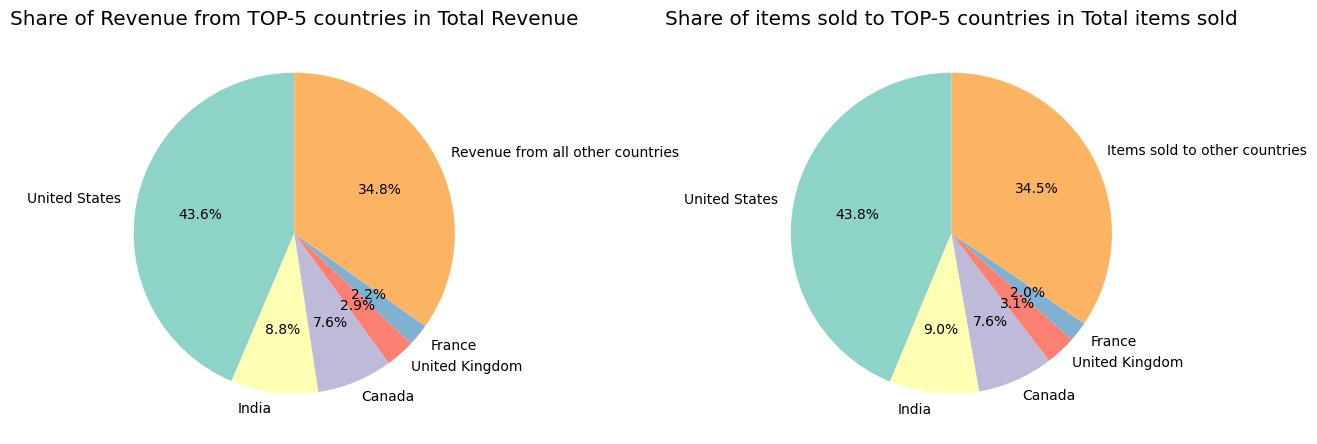

In [ ]:
# Перший пай чарт - по доходах
sizes1 = top_5_country_sales["Total sales"].fillna(0).tolist() + [
    max(0, total_sales - top_5_country_sales["Total sales"].fillna(0).sum())
]
labels1 = top_5_country_sales["country"].tolist() + ["Revenue from all other countries"]
colors1 = sns.color_palette("Set3", n_colors=len(labels1))

# Другий пай чарт - по проданих одиницях
sizes2 = top_5_country_items_sold["Items sold"].fillna(0).tolist() + [
    max(0, total_items_sold - top_5_country_items_sold["Items sold"].fillna(0).sum())
]
labels2 = top_5_country_items_sold["country"].tolist() + ["Items sold to other countries"]
colors2 = sns.color_palette("Set3", n_colors=len(labels2))

# Малюнок із 2 підграфіками
fig, ax = plt.subplots(1, 2, figsize=(13, 6))

ax[0].pie(sizes1, labels=labels1, colors=colors1, autopct='%1.1f%%', startangle=90)
ax[0].set_title("Share of Revenue from TOP-5 countries in Total Revenue")

ax[1].pie(sizes2, labels=labels2, colors=colors2, autopct='%1.1f%%', startangle=90)
ax[1].set_title("Share of items sold to TOP-5 countries in Total items sold")

plt.tight_layout()
plt.show()

Бачимо, що основним торговим партнером аналізованої компанії є США. І по принесеному доходу і по кількості проданих одиниць США дають майже половину всього обсягу. Це головний ринок компанії і водночас ризик концентрації.
Індія та Канада — другий ешелон. Вони стабільно входять у топ і за виручкою, і за кількістю проданих одиниць — виглядають як логічні ринки для масштабування (локалізація, способи оплати/доставки, промо).
Великий «довгий хвіст» інших країн - займають 34,8% по доходу і 34,5% по кількості проданих одиниць.
Розподіли виручки майже сходиться з розподілом проданих одиниць продукції. Частки майже збігаються на обох графіках, що свідчить, що середній чек/ціни по країнах схожі або продуктовий мікс не сильно відрізняється.

In [ ]:
grouped_by_continent_sales = (
    df.groupby("continent", as_index=False)["price"].sum()
      .rename(columns={"price": "Total sales"})
      .sort_values(by='Total sales', ascending = False)
)
top_3_continents_sales = grouped_by_continent_sales.head(3)
print("TOP-3 continents by Sales")
print(top_3_continents_sales)

grouped_by_continent_items_sold = (
    df.groupby("continent", as_index=False)["price"].count()
      .rename(columns={"price": "Items sold"})
      .sort_values(by='Items sold', ascending = False)
)
top_3_continents_items_sold = grouped_by_continent_items_sold.head(3)
print("TOP-3 continents by Items sold")
print(top_3_continents_items_sold)


TOP-3 continents by Sales
  continent  Total sales
2  Americas   17665280.0
3      Asia    7601298.3
4    Europe    5934624.2
TOP-3 continents by Items sold
  continent  Items sold
2  Americas       18553
3      Asia        7950
4    Europe        6261


/tmp/ipython-input-496569470.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipython-input-496569470.py:11: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



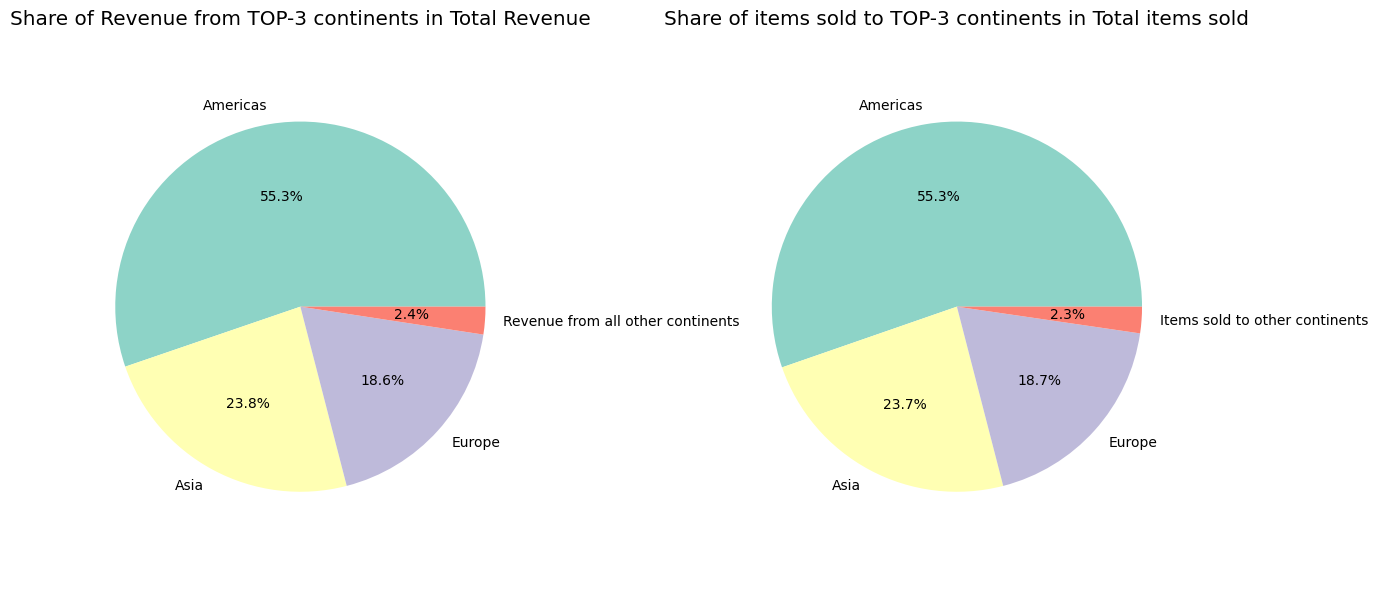

In [ ]:
total_sales = grouped_by_continent_sales['Total sales'].sum()
total_items = grouped_by_continent_items_sold['Items sold'].sum()

sum_top3_sales = top_3_continents_sales['Total sales'].sum()
sum_top3_items = top_3_continents_items_sold['Items sold'].sum()

labels1 = (
    top_3_continents_sales['continent']
        .astype('object')
        .fillna('Unknown')
        .tolist()
    + ['Revenue from all other continents']
)
sizes1 = (
    top_3_continents_sales['Total sales'].tolist()
    + [max(0, total_sales - sum_top3_sales)]
)
colors1 = sns.color_palette("Set3", n_colors=len(labels1))


labels2 = (
    top_3_continents_items_sold['continent']
        .astype('object')
        .fillna('Unknown')
        .tolist()
    + ['Items sold to other continents']
)
sizes2 = (
    top_3_continents_items_sold['Items sold'].tolist()
    + [max(0, total_items - sum_top3_items)]
)
colors2 = sns.color_palette("Set3", n_colors=len(labels2))

fig, ax = plt.subplots(1, 2, figsize=(13, 6))
ax[0].pie(sizes1, labels=labels1, colors=colors1, autopct='%1.1f%%', startangle=0); ax[0].axis('equal')
ax[0].set_title('Share of Revenue from TOP-3 continents in Total Revenue')

ax[1].pie(sizes2, labels=labels2, colors=colors2, autopct='%1.1f%%', startangle=0); ax[1].axis('equal')
ax[1].set_title('Share of items sold to TOP-3 continents in Total items sold')

plt.tight_layout()
plt.show()

Компанія співпрацює з 5 регіонами: Americas, Asia, Europe, Oceania, Africa(та є декілька замовлень з невідомою локацією), але бачимо, що є 3 регіона, які займають 97,6% по доходу і 97,7% по кількості проданих одиниць. Обидва показника також майже ідентичні по цих трьох континентах.

In [ ]:
top_10_pvt_table_category = (
    pd.pivot_table(
        df, values='price', index='category', aggfunc='sum'
    )
    .sort_values(by='price', ascending=False)
    .head(10)
    .reset_index()
)
top_10_pvt_table_category_usa = (
    pd.pivot_table(
        df[df["country"] == "United States"], values='price', index='category', aggfunc='sum'
    )
    .sort_values(by='price', ascending=False)
    .head(10)
    .reset_index()
)

/tmp/ipython-input-3401808955.py:2: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior

/tmp/ipython-input-3401808955.py:10: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior



In [ ]:
top_10_pvt_table_category_usa['category']

,category
0,Sofas & armchairs
1,Chairs
2,Beds
3,Bookcases & shelving units
4,Cabinets & cupboards
5,Outdoor furniture
6,Tables & desks
7,Chests of drawers & drawer units
8,Bar furniture
9,Children's furniture


In [ ]:
top_10_pvt_table_category["Share from total(%)"] = top_10_pvt_table_category["price"] / total_sales * 100
print(top_10_pvt_table_category)
print(f"TOP-10 categories share: {top_10_pvt_table_category["Share from total(%)"].sum():.2f}%")

top_10_pvt_table_category_usa["Share from total USA(%)"] = top_10_pvt_table_category_usa["price"] / df[df["country"] == "United States"]["price"].sum() * 100
print(top_10_pvt_table_category_usa)
print(f"TOP-10 categories share in USA: {top_10_pvt_table_category_usa["Share from total USA(%)"].sum():.2f}%")

                           category      price  Share from total(%)
0                 Sofas & armchairs  8388254.5            26.236473
1                            Chairs  6147748.8            19.228702
2                              Beds  4919725.0            15.387734
3        Bookcases & shelving units  3640818.1            11.387616
4              Cabinets & cupboards  2336499.5             7.308017
5                 Outdoor furniture  2142222.2             6.700363
6                    Tables & desks  1790307.5             5.599658
7  Chests of drawers & drawer units   906562.5             2.835513
8                     Bar furniture   735503.0             2.300479
9              Children's furniture   467697.0             1.462845
TOP-10 categories share: 98.45%
                           category      price  Share from total USA(%)
0                 Sofas & armchairs  3707144.5                26.586798
1                            Chairs  2619773.8                18.788422
2   

/tmp/ipython-input-4108116916.py:12: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/tmp/ipython-input-4108116916.py:27: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



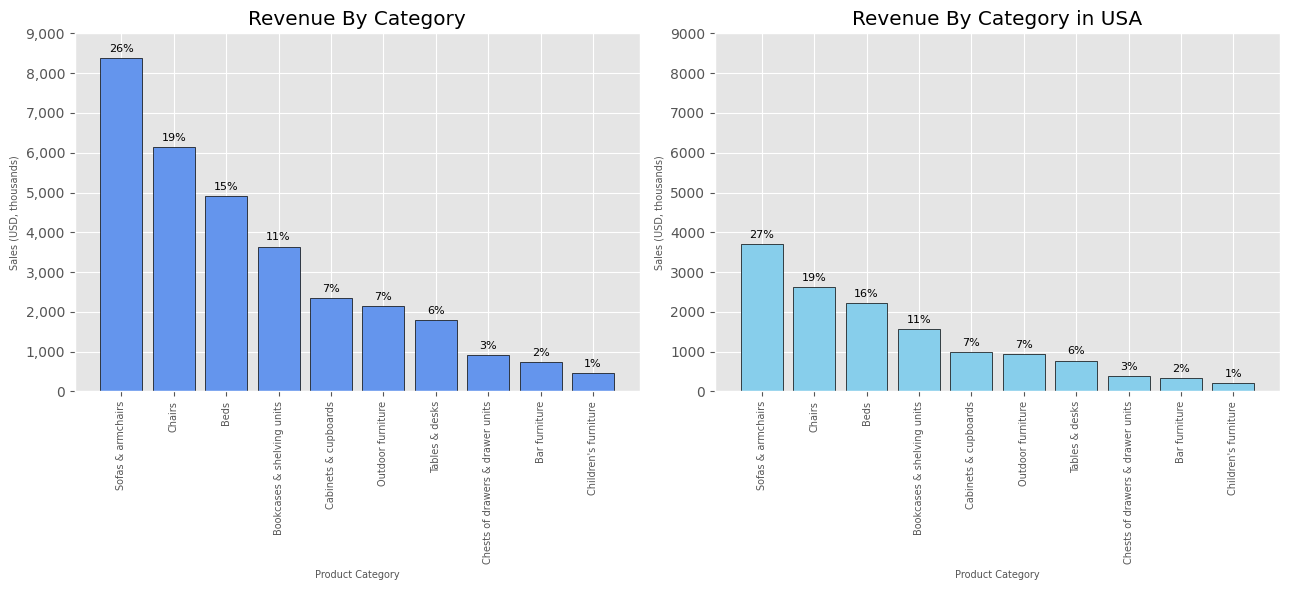

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(13, 6))
plt.style.use('ggplot')

bars0 = ax[0].bar(
    top_10_pvt_table_category['category'],
    top_10_pvt_table_category['price'] / 1000,
    color='cornflowerblue', edgecolor='black'
)
ax[0].set_title("Revenue By Category", color = "black")
ax[0].set_xlabel("Product Category",fontsize=7)
ax[0].set_ylabel("Sales (USD, thousands)",fontsize=7)
ax[0].set_xticklabels(top_10_pvt_table_category['category'], rotation=90, fontsize=7)
ax[0].ticklabel_format(style="plain", axis="y")
ax[0].set_ylim(0, 9000)
ax[0].yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))  # тисячні розділювачі
share_labels = [f"{v:.0f}%" for v in top_10_pvt_table_category["Share from total(%)"].to_numpy()]
ax[0].bar_label(bars0, labels=share_labels, padding=3, fontsize=8)

bars1 = ax[1].bar(
    top_10_pvt_table_category_usa['category'],
    top_10_pvt_table_category_usa['price'] / 1000,
    color='skyblue', edgecolor='black'
)
ax[1].set_title("Revenue By Category in USA", color = "black")
ax[1].set_xlabel("Product Category",fontsize=7)
ax[1].set_ylabel("Sales (USD, thousands)",fontsize=7)
ax[1].set_xticklabels(top_10_pvt_table_category_usa['category'], rotation=90, fontsize=7)
ax[1].ticklabel_format(style="plain", axis="y")
ax[1].set_ylim(0, 9000)
share_labels_usa = [f"{v:.0f}%" for v in top_10_pvt_table_category_usa["Share from total USA(%)"].to_numpy()]
ax[1].bar_label(bars1, labels=share_labels_usa, padding=3, fontsize=8)

plt.tight_layout()
plt.show()

Склад топ-10 категорій  збігається між глобальним ринком і топ-країною (США): у лідерах Sofas & armchairs, Chairs, Beds, Bookcases & shelving units; нижня частина — Cabinets & cupboards, Outdoor furniture, Tables & desks, Chests…, Bar furniture, Children’s furniture.
Розподіли схожі за формою: те, що добре продається глобально, добре продається і в топ-країні. %частка доходу від цих топ-10 категорій також майже повністю збігається для глобального ринку та США, відмінності мінімальні: 1% для Sofas & armchairs та Beds.

In [ ]:
pvt_table_ = (
    pd.pivot_table(
        df, values='price', index='category', aggfunc='sum'
    )
    .sort_values(by='price', ascending=False)
    .head(10)
    .reset_index()
)

/tmp/ipython-input-4172183782.py:2: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior



In [ ]:
grouped_by_device_sales = (
    df.groupby("device", as_index=False)["price"].sum()
      .rename(columns={"price": "Total sales"})
      .sort_values(by='Total sales', ascending = False)
)
print(grouped_by_device_sales)

grouped_by_browser_sales = (
    df.groupby("browser", as_index=False)["price"].sum()
      .rename(columns={"price": "Total sales"})
      .sort_values(by='Total sales', ascending = False)
)
grouped_by_browser_sales["Share from total(%)"] = grouped_by_browser_sales["Total sales"] / total_sales * 100
print(grouped_by_browser_sales)



    device  Total sales
0  desktop   18864039.0
1   mobile   12384225.8
2   tablet     723466.3
           browser  Total sales  Share from total(%)
2           Chrome   21826850.0            68.269215
5           Safari    7526544.0            23.541246
0          <Other>     923354.8             2.888035
3             Edge     716444.3             2.240868
4          Firefox     567523.6             1.775079
1  Android Webview     411014.4             1.285556


/tmp/ipython-input-1906276473.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipython-input-1906276473.py:9: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



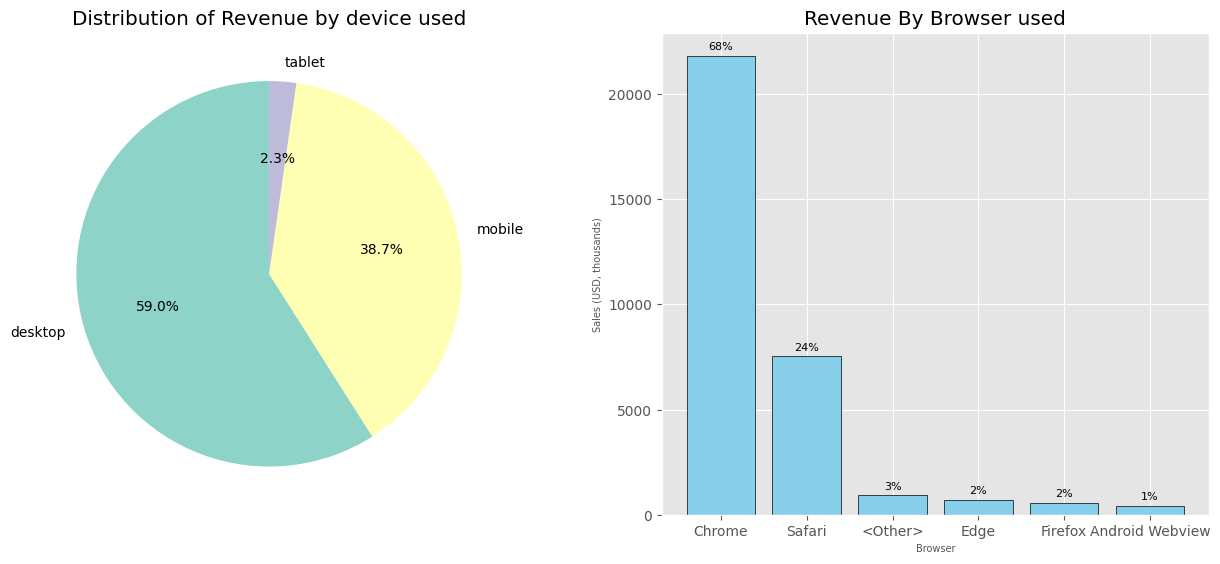

In [ ]:
total_sales = df["price"].sum()

sizes1 = grouped_by_device_sales["Total sales"].tolist()
labels1 = grouped_by_device_sales["device"].tolist()
colors1 = sns.color_palette("Set3", n_colors=len(labels1))

# Малюнок із 2 підграфіками
fig, ax = plt.subplots(1, 2, figsize=(13, 6))

ax[0].pie(sizes1, labels=labels1, colors=colors1, autopct='%1.1f%%', startangle=90)
ax[0].set_title("Distribution of Revenue by device used")

bars1 = ax[1].bar(
    grouped_by_browser_sales['browser'],
    grouped_by_browser_sales["Total sales"] / 1000,
    color='skyblue', edgecolor='black'
)
ax[1].set_title("Revenue By Browser used", color = "black")
ax[1].set_xlabel("Browser",fontsize=7)
ax[1].set_ylabel("Sales (USD, thousands)",fontsize=7)
ax[1].ticklabel_format(style="plain", axis="y")
share_labels_browser = [f"{v:.0f}%" for v in grouped_by_browser_sales["Share from total(%)"].to_numpy()]
ax[1].bar_label(bars1, labels=share_labels_browser, padding=3, fontsize=8)

plt.tight_layout(pad=2.0, w_pad=2.5)
plt.show()

Виручка йде переважно з desktop (59%), далі mobile (39%), tablet — найменша частка (2%). Тобто десктоп залишається основним каналом.
Браузери. Дуже висока концентрація: Chrome приблизно 2/3 виручки, Safari ≈ 1/4; решта (Edge/Firefox/Android WebView/Other) — дрібні частки. Це означає:
пріоритетно тестувати й оптимізувати Chrome та Safari (перформанс, A/B);
критичні сценарії QA покривати саме на цих двох браузерах і на desktop + mobile.

Далі перевіримо конверсію по desktop vs mobile: якщо на мобільному нижче — знайти вузькі місця (форма оплати, швидкість, зручність кошика).


In [ ]:
grouped_by_device_browser = (df.groupby(["device", "browser"], as_index=False)["price"].sum()
                              .rename(columns={"price": "Total sales"})
                              .sort_values(by=['device','Total sales'], ascending = False)
                              )
grouped_by_device_browser

/tmp/ipython-input-3526018090.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



,device,browser,Total sales
14,tablet,Chrome,381265.9
17,tablet,Safari,262763.8
12,tablet,<Other>,60808.6
13,tablet,Android Webview,18628.0
15,tablet,Edge,0.0
16,tablet,Firefox,0.0
11,mobile,Safari,5748221.2
8,mobile,Chrome,5667208.9
6,mobile,<Other>,544545.3
7,mobile,Android Webview,392386.4


/tmp/ipython-input-1798249087.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



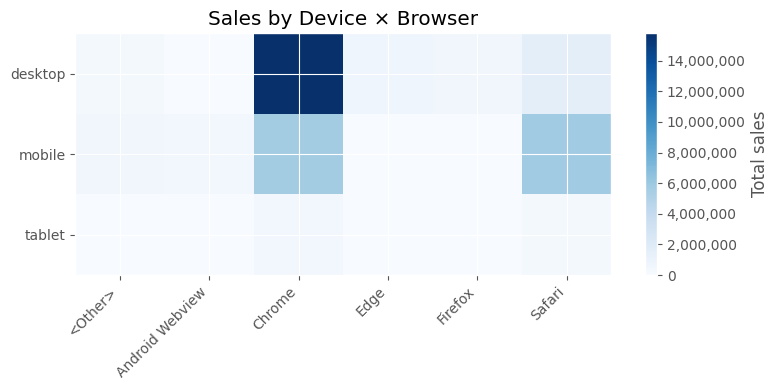

In [ ]:
top_browsers = (grouped_by_device_browser.groupby('browser')['Total sales']
                .sum().sort_values(ascending=False).head(8).index)

pivot = grouped_by_device_browser.pivot(index='device', columns='browser', values='Total sales').fillna(0)

# heatmap
plt.figure(figsize=(8,4))
# im = plt.imshow(pivot.values, aspect='auto', cmap='Blues')  # головний рядок
# plt.colorbar(im, label='Total sales')

im = plt.imshow(pivot.values, aspect='auto', cmap='Blues')
cb = plt.colorbar(im, label='Total sales')
cb.ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

plt.xticks(np.arange(pivot.shape[1]), pivot.columns, rotation=45, ha='right')
plt.yticks(np.arange(pivot.shape[0]), pivot.index)
plt.title('Sales by Device × Browser')
plt.tight_layout()

plt.show()

Головний осередок доходу — на desktop браузер Chrome. Це найтемніша клітинка: на десктопі, у Chrome, зосереджена найбільша частка виручки.
Desktop, браузер Safari також сильний, але помітно поступається Chrome.
Mobile × Safari — найбільший внесок, Mobile × Chrome — менший, але суттєвий.
Тож ми бачимо, що мобільний канал важливий, але не домінує.
Tablet майже не впливає на дохід у всіх браузерах — низький пріоритет.
Edge/Firefox/Android WebView дають незначну частку на всіх девайсах.
Наступні кроки: перевірити конверсію на мобільних пристроях(товари у кошику, способи оплати, час знаходження на сайті, зручність інтерфейсу) як можливість підвищити конверсію.

In [ ]:
registered_users = df[df['user_id'].notna()]
unregistered_users = df[~df['user_id'].notna()]
unsubscribed = registered_users[registered_users['is_subscribed'] == False]
subscribed = registered_users[registered_users['is_subscribed'] == True]
verified = registered_users[registered_users['is_verified'] == True]
unverified = registered_users[registered_users['is_verified'] == False]

unsubscribed_count = unsubscribed.shape[0]
registered_users_count = registered_users.shape[0]
verified_users_count = verified.shape[0]

share_of_unsubscribed = unsubscribed_count / registered_users_count * 100
share_of_verified = verified_users_count / registered_users_count * 100

print(f'Share of subscribed users: {100 - share_of_unsubscribed:.2f}%')
print(f'Share of verified users: {share_of_verified:.2f}%')

Share of subscribed users: 83.06%
Share of verified users: 71.70%


1) Підписаних серед зареєстрованих 83%, що є гарним результатом. У базі залишилось 17% «unsubscribed».
2) Email-верифікованих ~72% кожен третій акаунт без підтвердженої пошти. Це явно вузьке місце для залучення/ретеншну.


Що це означає для компанії:  
Без верифікації втрачається частину каналів комунікації (тригерні листи, ресети паролів).
Висока частка підписаних не гарантує монетизації — ключове, чи верифікували вони пошту.
Рекомендації:

1. Флоу верифікації
* Показувати blocking-нагадування до завершення ключової дії (покупки, збереження кошика).
* Повторні нагадування з прорахованою частотою: 10 хв, 24 год,  3 дні.
* Маленька винагорода після верифікації (знижка/безкоштовна доставка), якщо політика дозволяє.

2. Preference center & частота
* Дати користувачу вибір типів листів і частоти (daily/weekly/monthly).
* Для «майже-unsubscribed» зробити зробити відправку меншої кількості листів для запобігання повної відписки.

3. Для відписаних (їх ~17%)
Перевіряємо, як вони купують vs підписані: якщо відставання істотне — таргетована робота з onsite-персоналізацією.

4. Експерименти
A/B: текст теми, таймінг, CTA верифікації, бар’єри в онбордингу (коли просимо verify).

In [ ]:
sales_registered_sum = registered_users["price"].sum()
sales_registered_cnt_items =  registered_users["price"].count()

sales_unregistered_sum = unregistered_users["price"].sum()
sales_unregistered_cnt_items = unregistered_users["price"].count()

sales_subscribed_sum = subscribed["price"].sum()
sales_unsubscribed_sum = unsubscribed["price"].sum()

sales_verified_sum = verified["price"].sum()
sales_unverified_sum = unverified["price"].sum()

print(
    f"""
- Registered users purchased goods worth ${sales_registered_sum:,.0f}, sold items: {sales_registered_cnt_items:,}.
- Unregistered users purchased goods worth ${sales_unregistered_sum:,.0f}, sold items: {sales_unregistered_cnt_items:,} .

- Subscribed users generated ${sales_subscribed_sum:,.0f} in sales.
- Unsubscribed users generated ${sales_unsubscribed_sum:,.0f} in sales.

- Verified users generated ${sales_verified_sum:,.0f} in sales.
- Unverified users generated ${sales_unverified_sum:,.0f} in sales.

Total sales considered: ${total_sales:,.0f}.
"""
)



- Registered users purchased goods worth $2,582,518, sold items: 2,781.
- Unregistered users purchased goods worth $29,389,213, sold items: 30,757 .

- Subscribed users generated $2,150,797 in sales.
- Unsubscribed users generated $431,722 in sales.

- Verified users generated $1,866,017 in sales.
- Unverified users generated $716,501 in sales.

Total sales considered: $31,971,731.



В нас вже виявлено зони для розвитку.
1. За 3 досліджувані місяці жоден з акаунтів не зробив повторну покупку, ми не розуміємо наразі причини неповернення клієнтів.
2. Майже всі гроші приносять гості без акаунта. Близько 92% виручки — від незареєстрованих користувачів. Це добре для швидкої покупки, але погано для повторних продажів: у нас немає контакту з людиною після чекауту.
3. Серед тих, хто має акаунт, основний дохід дають  користувачі підписані та з підтвердженою поштою. Саме вони купують частіше та на більші суми. Непідписані і непідтверджені — значно слабші.

Пропозиції:
*  Задача для відділу якості: прокомунікувати з клієнтами що не здійснили повторної покупки для розуміння причин/запропонувати знижку на наступну покупку.
* Найближчий резерв зростання — перетворити частину гостей у власників акаунтів і довести їх до підтвердження email.

* Не чіпаємо швидкість гостьового чекауту(щоб не зменшити кількість продажів що наразі маємо), але додаємо м’який перехід у акаунт:
 1) Після оплати — один клік «забрати акаунт» (magic-link без пароля, соцлогін).
2) Автоматично створюємо «легкий акаунт» на email з замовлення, пропонуємо підвищити рівень — історія замовлень, відстеження, гарантія, бали.
3) Пояснюємо користь акаунта прямо в кошику:
Короткий блок: «статус замовлення, швидке повернення, збережені адреси, персональні пропозиції».
4)A/B-тест: чи можемо зібрати email перед оплатою без падіння конверсії.
5)Дотискаємо підтвердження пошти (verification):
Magic-link + ввічливі нагадування (через 10 хв → 24 год → 3 дні).
6)Маленька винагорода за підтвердження (якщо політика дозволяє): знижка/доставка.
7) Хто вже відписався — комунікуємо через інші канали: push, SMS, банери на сайті.

In [ ]:
registered_users_group_country = (
    registered_users.groupby(by="country", as_index=False)["user_id"].count()
    .rename(columns={"user_id": "Number of accounts"})
    .sort_values(by="Number of accounts", ascending = False)
)
# registered_users_group_country["Revenue from country"] =

/tmp/ipython-input-1463779971.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [ ]:
grouped_by_country_sales

,country,Total sales
104,United States,13943553.9
43,India,2809762.0
18,Canada,2437921.0
103,United Kingdom,938317.9
33,France,710692.8
...,...,...
8,Bahamas,2411.0
38,Guatemala,2259.0
36,Ghana,1018.0
14,Bosnia & Herzegovina,939.0


# Statistics accounts&revenue by country

In [ ]:
merged_country_acc = pd.merge(registered_users_group_country, grouped_by_country_sales, on='country')
merged_country_acc

,country,Number of accounts,Total sales
0,United States,12384,13943553.9
1,India,2687,2809762.0
2,Canada,2067,2437921.0
3,United Kingdom,859,938317.9
4,France,553,710692.8
...,...,...,...
103,Honduras,4,6861.0
104,Paraguay,4,8371.0
105,Mongolia,4,3431.0
106,Trinidad & Tobago,4,6967.0


In [ ]:
number_of_accounts = merged_country_acc["Number of accounts"].tolist()
revenue = merged_country_acc["Total sales"].tolist()

# Normaltest
_, p_value_normaltest_number_of_acc = normaltest(number_of_accounts)
_, p_value_normaltest_revenue = normaltest(revenue)

# Shapiro-Wilk test
_, p_value_shapiro_number_of_acc = shapiro(number_of_accounts)
_, p_value_shapiro_revenue = shapiro(revenue)

print(f"Normaltest for number of accounts p-value: {p_value_normaltest_number_of_acc}")
print(f"Normaltest for revenue p-value: {p_value_normaltest_revenue}")

print(f"Shapiro-Wilk for number of accounts p-value: {p_value_shapiro_number_of_acc}")
print(f"Shapiro-Wilk for revenue p-value: {p_value_shapiro_revenue}")

Normaltest for number of accounts p-value: 2.322081196688478e-48
Normaltest for revenue p-value: 1.951632189958333e-48
Shapiro-Wilk for number of accounts p-value: 6.495252202264297e-22
Shapiro-Wilk for revenue p-value: 6.940722856167402e-22


Висновок по тестам на нормальність розподілу: І D’Agostino/Pearson normaltest, і Shapiro–Wilk дали дуже малі p-value як для Number of accounts, так і для Total sales.
Це означає, що на рівні країн обидві змінні не розподілені нормально (ймовірно, правоскосі: є кілька великих країн, решта — значно менші).
Що з цього випливає:
Для оцінки зв’язку краще спиратися на рангову кореляцію Спірмена.

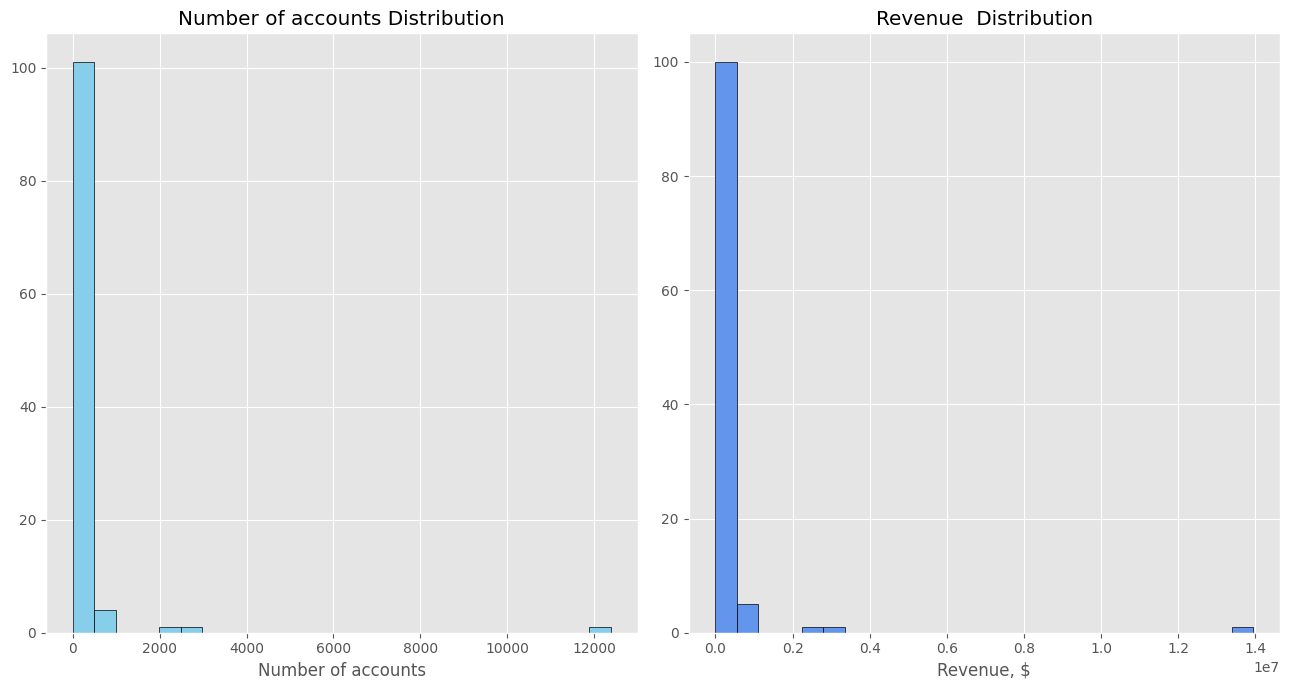

In [ ]:
plt.figure(figsize=(13, 7))

# number_of_accounts distribution
plt.subplot(1, 2, 1)
plt.hist(number_of_accounts, bins=25, color="skyblue", edgecolor="black")
plt.title("Number of accounts Distribution")
plt.xlabel("Number of accounts")

# revenue distribution
plt.subplot(1, 2, 2)
plt.hist(revenue, bins=25, color="cornflowerblue", edgecolor="black")
plt.title("Revenue  Distribution")
plt.xlabel("Revenue, $")

plt.tight_layout()
plt.show()




Правосторонній скос - багато значень з малими значеннями і декілька "викидів" з великими.

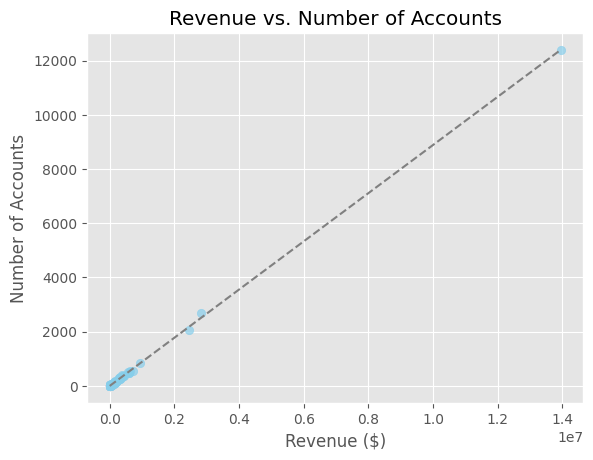

In [ ]:
plt.scatter(revenue, number_of_accounts, color="skyblue", alpha=0.7)

plt.title("Revenue vs. Number of Accounts")
plt.xlabel("Revenue ($)")
plt.ylabel("Number of Accounts")

z = np.polyfit(revenue, number_of_accounts, 1)
x_line = np.linspace(min(revenue), max(revenue), 100)
plt.plot(x_line, np.polyval(z, x_line), '--', color='gray')

plt.show()

In [ ]:
print( f"Test statistic and p-value: {spearmanr(revenue, number_of_accounts)}")

Test statistic and p-value: SignificanceResult(statistic=np.float64(0.9607744011723134), pvalue=np.float64(7.297249328838091e-61))


Кореляція Спірмена p ≈ 7.3×10⁻⁶¹(значно менше за загальноприйняте значення 0.05).
Це дуже сильний позитивний монотонний зв’язок між кількістю зареєстрованих акаунтів і виручкою по країнах. Імовірність отримати такий результат випадково практично нульова.  
Висновок:  
Країни, де більше зареєстрованих користувачів, як правило, мають і вищі продажі.
Висновок є стійким, бо тест Спірмена не вимагає нормальності даних і добре працює на скошених розподілах.

# Analysis of sales dynamics.

In [ ]:
df.head()

,session_date,session_id,continent,country,device,browser,mobile_model_name,operating_system,language,source,channel,user_id,is_verified,is_subscribed,category,product_name,price,short_description
0,2020-11-01,5760483956,Americas,United States,desktop,Chrome,Safari,Macintosh,zh,<Other>,Paid Search,NaN,<NA>,<NA>,Bookcases & shelving units,VITTSJÖ,609.0,"Shelving unit with laptop table, 202x36x175 cm"
1,2020-11-01,7115337200,Europe,United Kingdom,desktop,Chrome,Chrome,Web,en-us,organic,Organic Search,NaN,<NA>,<NA>,Bookcases & shelving units,VITTSJÖ,609.0,"Shelving unit with laptop table, 202x36x175 cm"
2,2020-11-01,3978035233,Europe,Norway,mobile,Chrome,<Other>,Web,zh,(none),Direct,NaN,<NA>,<NA>,Tables & desks,RÅSKOG,189.0,"Trolley, 35x45x78 cm"
3,2020-11-01,9648986282,Africa,Nigeria,mobile,Chrome,<Other>,Android,es-es,(none),Direct,NaN,<NA>,<NA>,Bookcases & shelving units,VITTSJÖ,609.0,"Shelving unit with laptop table, 202x36x175 cm"
4,2020-11-01,4393441533,Asia,China,desktop,Chrome,Chrome,Windows,en-us,(none),Direct,NaN,<NA>,<NA>,Bookcases & shelving units,VITTSJÖ,609.0,"Shelving unit with laptop table, 202x36x175 cm"


In [ ]:
grouped_by_date = (
    df.groupby(by="session_date", as_index=False)["price"].sum()
    .rename(columns={"price": "Total sales"})
    .sort_values(by='session_date')
)
grouped_by_date

,session_date,Total sales
0,2020-11-01,244292.5
1,2020-11-02,355506.8
2,2020-11-03,498979.6
3,2020-11-04,339187.1
4,2020-11-05,391276.6
...,...,...
87,2021-01-27,286340.7
88,2021-01-28,0.0
89,2021-01-29,0.0
90,2021-01-30,0.0


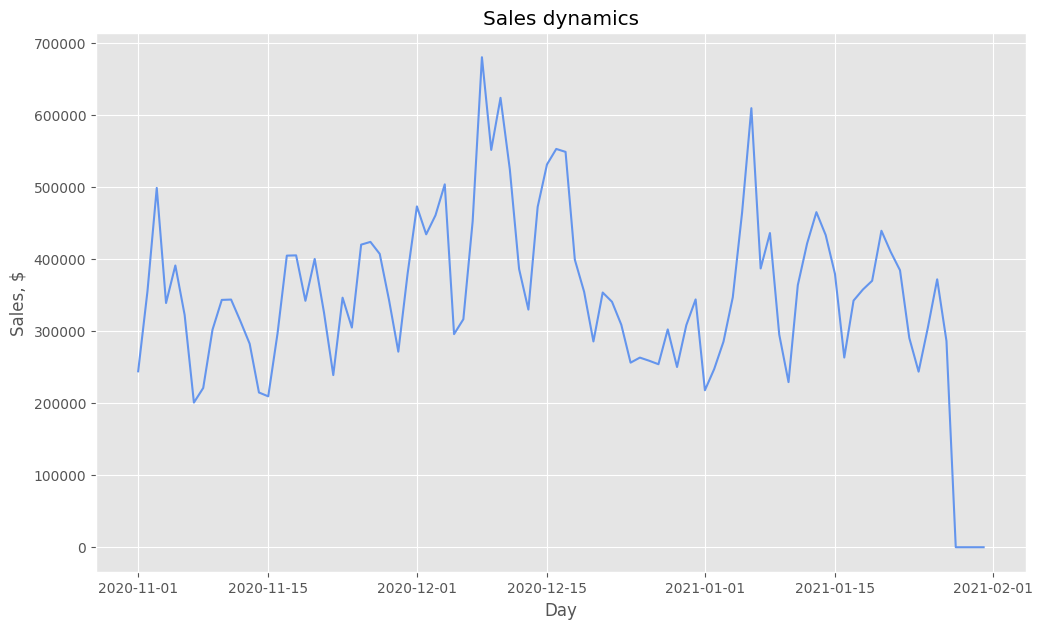

In [ ]:
plt.figure(figsize=(12, 7))
plt.plot(grouped_by_date["session_date"], grouped_by_date["Total sales"], color="cornflowerblue")
plt.title("Sales dynamics")
plt.xlabel("Day")
plt.ylabel("Sales, $")  # Y-axis label
plt.show()


Динаміка продажів по днях показує, що є постійні провали - скоріш за все через сезонність продажу по днях тижня. Надалі перевіримо динаміку продажів по тижнях і структуру по днях тижня.

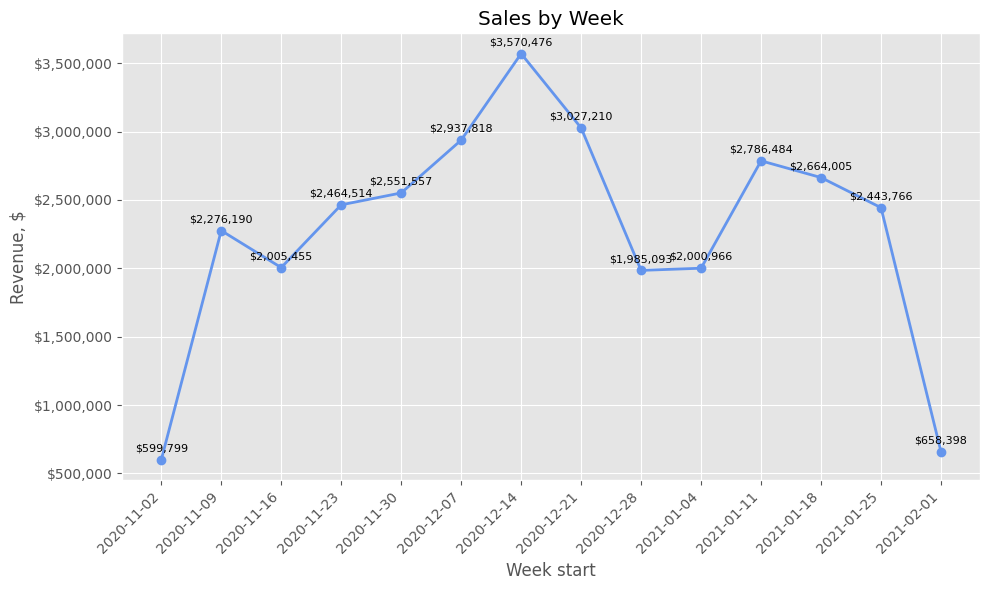

In [ ]:
weekly = (grouped_by_date
          .set_index('session_date')
          .resample('W-MON')['Total sales'].sum()
          .rename_axis('week_start').reset_index())

# Лінійний графік
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(weekly['week_start'], weekly['Total sales'], marker='o', linewidth=2, color ="cornflowerblue")

# ОСІ
ax.set_title('Sales by Week')
ax.set_xlabel('Week start')
ax.set_ylabel('Revenue, $')
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))

# тижневі тики + формат дати
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

# Підписи над точками
for x, y in zip(weekly['week_start'], weekly['Total sales']):
    ax.annotate(f"${y:,.0f}", (x, y), xytext=(0, 6),
                textcoords='offset points', ha='center', fontsize=8)

plt.tight_layout()
plt.show()

Динаміка продажів за тижнями показала, що:
З початку листопада виручка поступово зростає, пік — середина грудня.Що можна охарактеризувати передсвятковий сплеск(для перевірки даних можна перевірити динаміку попередніх років).
Далі — просідання в кінці грудня – на початку січня (свята, менше доставок, перенесення покупок).
Середина січня дає помітне відновлення, після чого йдемо на спад до початку лютого.
Висновок: є чітка сезонність. Планувати склад/закупівлі/доставку й маркетингові бюджети під пік грудня; не очікувати високих обсягів на перших тижнях січня.
Поради до подальших дій:
1) Підняти бюджети та запас популярних категорій на листопад-середину грудня; на кінець грудня–початок січня — акції на залишки/новорічні колекції, щоб розвантажити склад і товари не простоювали в "тихі" місяціі.
2) Перевірити терміни доставки перед святами, чи через високий попит і як наслідок довгий термін доставки вони не призводять до зменшення закупок/відміну зроблених замовлень.


In [ ]:
grouped_by_continent_date = (
    df.groupby(['session_date', 'continent'], as_index=False)['price']
      .sum()
      .rename(columns={'price': 'Total sales'})
)


weekly_by_continent = (
    grouped_by_continent_date
      .groupby('continent')
      .resample('W-MON', on='session_date')['Total sales']
      .sum()
      .reset_index()
      .rename(columns={'session_date': 'week_start'})
      .sort_values(['continent','week_start'])
)

fig = px.line(
    weekly_by_continent,
    x='week_start', y='Total sales',
    color='continent',
    markers=True,
    color_discrete_map={'Americas':'#4e79a7','Asia':'#f28e2b','Europe':'#59a14f'},
    title='Weekly Sales by Device'
)
fig.update_yaxes(title='Revenue, $', tickformat=',')
fig.update_xaxes(title='Week start')
fig.update_layout(legend_title_text='Continent')
fig.show()

/tmp/ipython-input-1231572626.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipython-input-1231572626.py:10: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



По динаміці виручки ТОП-3 континентах бачимо:  
1) Americas — беззаперечний лідер по виручці. Найвищі рівні весь період, чіткий ріст до піку в середині грудня , далі різкий спад на свята/початок січня, коротке відновлення в середині січня і зниження наприкінці місяця. Саме цей регіон формує загальну сезонність і динаміка по ньому співпалдає з загальною динамікою продажів.  
2) Asia — стабільно друге місце. Поступове зростання до початку/середини грудня, потім спад у кінці грудня, помірне відновлення в січні, наприкінці місяця знову зниження.  
3) Europe — третє місце зі схожаю динамікою: плавний ріст до грудневого піку, спад на свята, невелике підняття в середині січня і спад наприкінці місяця.  
4) Africa / Oceania / (not set) — мізерні обсяги; на тренд майже не впливають.  

Висновки
Є спільна сезонність для трьох основних регіонів: ріст до середини грудня далі спад у період свят/початку січня - коротке відновлення в середині січня - зниження до початку лютого.
Американський ринок визначає «вершини й падіння» сумарної виручки; Азія та Європа рухаються в тому ж ритмі, але з меншими амплітудами.  
Рекомендації:  
Планування піків: збільшити запаси, логістику і бюджети на листопад–середину грудня у всіх трьох регіонах, особливо в Americas.
Кінець грудня – початок січня: закласти просідання попиту; використовувати розпродажі залишків, гнучкі умови доставки, ремаркетинг.  

Локалізація промо:
Americas — фокус на holiday season (до середини грудня), потім утримання чеком/доставкою.
Asia — врахувати локальні події (початок року, підготовка до регіональних свят).
Europe — перевірити чутливість до строків доставки та гарантій; чітко комунікувати дедлайни перед святами.

In [ ]:
grouped_by_device_date = (
    df.groupby(['session_date', 'device'], as_index=False)['price']
      .sum()
      .rename(columns={'price': 'Total sales'})
)


weekly_by_device = (
    grouped_by_device_date
      .groupby('device')
      .resample('W-MON', on='session_date')['Total sales']
      .sum()
      .reset_index()
      .rename(columns={'session_date': 'week_start'})
      .sort_values(['device','week_start'])
)

fig = px.line(
    weekly_by_device,
    x='week_start', y='Total sales',
    color='device',
    markers=True,
    color_discrete_map={'desktop':'#4e79a7','mobile':'#f28e2b','tablet':'#59a14f'},
    title='Weekly Sales by Device'
)
fig.update_yaxes(title='Revenue, $', tickformat=',')
fig.update_xaxes(title='Week start')
fig.update_layout(legend_title_text='Device')
fig.show()

/tmp/ipython-input-1680315259.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipython-input-1680315259.py:10: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Загальний висновок з динаміки по девайсах (по тижнях):
1) Desktop — головний драйвер виручки. Має найбільшу амплітуду й чітко формує грудневий пік (приблизно вдвічі-втричі вище за mobile; tablet — мізерний внесок). Будь-які коливання desktop одразу видно на сумарній виручці.
2) Mobile — другий за внеском, але стабільніший. Повторює сезонний патерн (зростання до середини грудня - просідання на свята - відновлення в середині січня - спад), але з меншою волатильністю. Він може "підстрахувати" у випадку падіння по Tablet.
3) Tablet — мінімальний канал. Тримається на низькому рівні весь період; вклад у пік грудня є, але не впливає на загальну картину.  
Рекомендації:  
Планування піку (листопад–середина грудня):
* Основний акцент на desktop-кампанії (каталог/пошук, ремаркетинг)
* Mobile підсилюємо простими офферами.
* Свята та перші тижні січня: очікуваний просад на обох каналах: гнучкі промо на залишки, утримання чеків (відстрочка доставки) з упором на mobile.
* Січневий відкат і далі: підтримуючі активності; тестуємо desktop-креативи для швидкого «повернення» інтересу та mobile-UX (оплата в один тап, автозаповнення).
* Tablet: мінімальний пріоритет. Достатньо базової підтримки.
Коротко: сезонність однакова на всіх девайсах, але desktop визначає вершини й падіння, mobile згладжує це падіння.

In [ ]:
grouped_by_date["week_day"] = grouped_by_date["session_date"].dt.day_name()
grouped_by_date

,session_date,Total sales,week_day
0,2020-11-01,244292.5,Sunday
1,2020-11-02,355506.8,Monday
2,2020-11-03,498979.6,Tuesday
3,2020-11-04,339187.1,Wednesday
4,2020-11-05,391276.6,Thursday
...,...,...,...
87,2021-01-27,286340.7,Wednesday
88,2021-01-28,0.0,Thursday
89,2021-01-29,0.0,Friday
90,2021-01-30,0.0,Saturday


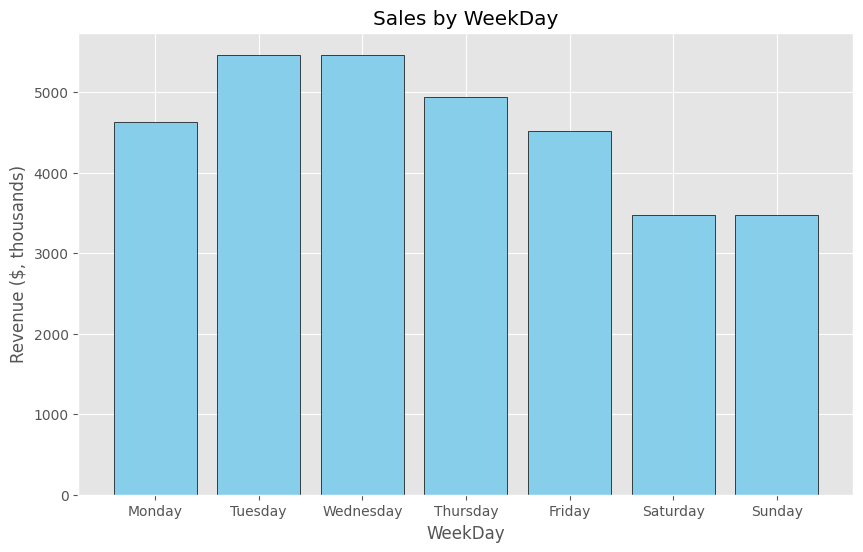

In [ ]:
group_by_week_day = grouped_by_date.groupby(by = "week_day", as_index=False)["Total sales"].sum()
group_by_week_day["Total sales in thousands"] = group_by_week_day["Total sales"] / 1000

days_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
ordered_data = group_by_week_day.set_index("week_day").loc[days_order].reset_index()

plt.figure(figsize=(10,6))
plt.bar(ordered_data["week_day"], ordered_data["Total sales in thousands"], color="skyblue", edgecolor = "black")
plt.title("Sales by WeekDay")
plt.xlabel("WeekDay")
plt.ylabel("Revenue ($, thousands)")
plt.show()

Продажі за днями тижня (структура):
* Найсильніші дні — вівторок і середа (найбільші продажі).
* Четвер трохи нижче, понеділок — середній.
* П’ятниця слабша, вихідні (субота/неділя) — найнижчі за виручкою.
Висновок: попит концентрується в середині робочого тижня; на вихідних аудиторія менш активна в виборі меблів або конвертує гірше.  
Рекомендації:  
Маркетинг: основні розсилки/акції — у вівторок–середу; і нагадування — у четвер.  
Вихідні: протестувати мобільні промо (бо трафік часто мобільний), простіші оффери та короткі чек-аути; підняти ставки у Paid Search тільки якщо є ріст CR.  
Операційно: планувати пік навантаження складу/підтримки на середину тижня.  
Аналітика: порівняти traffic vs revenue by weekday — якщо на вихідних трафіку багато, а виручка слабша, копати конверсію мобільного.
Підсумок: сезонний максимум — середина грудня; у тижні найкраще продаємо вт–ср, найгірше — сб–нд. Використай це для розкладу промо, бюджетів, стоків і графіків команд.

In [ ]:
sales_df = df.copy()
sales_df["has_purchase"] = sales_df["price"].apply(lambda x: 1 if x > 0 else 0)
sales_df["week_day"] = sales_df["session_date"].dt.day_name()

sales_by_weekday = sales_df.groupby(by=["week_day", "device"], as_index=False).agg(
    {"has_purchase": "sum", "session_id": "count"}
)
sales_by_weekday["conversion_sales(%)"] = sales_by_weekday["has_purchase"] / sales_by_weekday["session_id"] * 100
sales_by_weekday


/tmp/ipython-input-3803770678.py:5: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



,week_day,device,has_purchase,session_id,conversion_sales(%)
0,Friday,desktop,2701,28978,9.320864
1,Friday,mobile,1786,19497,9.160384
2,Friday,tablet,99,1128,8.776596
3,Monday,desktop,2929,29253,10.012648
4,Monday,mobile,1916,19668,9.741712
5,Monday,tablet,117,1148,10.191638
6,Saturday,desktop,2133,23005,9.271897
7,Saturday,mobile,1518,15643,9.704021
8,Saturday,tablet,73,875,8.342857
9,Sunday,desktop,2264,23265,9.731356


In [ ]:
confversion_df = sales_by_weekday.copy()
confversion_df['conversion_sales(%)'] = pd.to_numeric(confversion_df['conversion_sales(%)'], errors='coerce')

days = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
confversion_df['week_day'] = pd.Categorical(confversion_df['week_day'], categories=days, ordered=True)
confversion_df = confversion_df.sort_values('week_day')

colors = {"desktop":"#4e79a7","mobile":"#f28e2b","tablet":"#59a14f"}

fig = go.Figure()
for dev, sub in confversion_df.groupby('device'):
    fig.add_trace(go.Scatter(
        x=sub['week_day'], y=sub['conversion_sales(%)'],
        mode='lines+markers',
        name=dev, line=dict(color=colors.get(dev)),
        hovertemplate=('Day: %{x}<br>Device: '+dev+
                       '<br>Conversion: %{y:.2f}%'
                       '<br>Sessions: %{customdata[0]:,}'
                       '<br>Purchases: %{customdata[1]:,}<extra></extra>'),
        customdata=sub[['session_id','has_purchase']].to_numpy()
    ))

fig.update_layout(
    title='Conversion by Weekday × Device',
    xaxis_title='Week day',
    yaxis_title='Conversion, %',
    legend_title_text='Device'
)
fig.show()


/tmp/ipython-input-1357860394.py:11: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [ ]:
sessions_col = "session_id"
val_col = sessions_col

sessions_df = sales_by_weekday.copy()
sessions_df[val_col] = pd.to_numeric(sessions_df[val_col], errors="coerce")

days = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
sessions_df["week_day"] = pd.Categorical(sessions_df["week_day"], categories=days, ordered=True)
sessions_df = sessions_df.sort_values("week_day")

devices = ["desktop","mobile","tablet"]
colors  = {"desktop":"#4e79a7","mobile":"#f28e2b","tablet":"#59a14f"}

fig = go.Figure()
shown = {d: False for d in devices}

for day in days:
    sub = sessions_df[sessions_df["week_day"] == day]
    if sub.empty:
        continue

    vals = []
    for d in devices:
        row = sub[sub["device"] == d]
        if not row.empty:
            y   = float(row.iloc[0][val_col])
            pur = int(row.iloc[0]["has_purchase"])
            vals.append((d, y, pur))

    vals.sort(key=lambda t: t[1], reverse=True)
    for d, y, pur in vals:
        fig.add_bar(
            x=[day], y=[y], name=d,
            marker_color=colors.get(d, "#888"),
            marker_line_color="rgba(0,0,0,0.35)",
            marker_line_width=1,
            showlegend=not shown[d],
            hovertemplate=(f"Day: {day}<br>Device: {d}<br>"
                           f"Sessions: {y:,.0f}<br>Purchases: {pur:,.0f}<extra></extra>")
        )
        shown[d] = True

fig.update_layout(
    barmode="overlay",
    bargap=0.25,
    title="Sessions by Weekday × Device (overlapping; smallest on top)",
    xaxis_title="Week day",
    yaxis_title="Sessions",
    legend_title_text="Device",
)
fig.update_yaxes(tickformat=",")

fig.show()


Висновки:  
1) Пік продажів — вівторок/середа. Це узгоджується з піком сесій у ці дні.
2) Вихідні — найслабші за виручкою. Сесій менше, а конверсія не перекриває падіння трафіку.
Розподіл трафіку за девайсами: щодня домінує desktop, далі mobile, tablet — мізерна частка.
3) Конверсія за девайсами і днями: Desktop: відносно стабільно 9.2–10.1%. Легкий спад у чт–пт, підйом у нд. Mobile: трохи нижча за desktop у будні (~9.2–9.7%), покращується у вихідні (особливо сб–нд).
Tablet: найнижча й волатильна; провал чт–сб.  
Отже, будні дають виручку за рахунок вищого обсягу сесій (особливо вт–ср), тоді як на вихідних частково рятує краща конверсія mobile, але її не вистачає, бо трафіку менше.

Ключовий драйвер — обсяг трафіку у середині тижня; конверсія додає нюанси:
desktop сильний у будні; mobile відносно кращий у вихідні; tablet — «больове місце».
Падіння виручки у вихідні через поєднання (менший трафік + у частини девайсів нижча конверсія).
Рекомендації:  

1) Основні запуски/розсилки/перформанс-бюджети — вівторок/середа; нагадування — четвер.  
2) Вихідні = mobile-фокус: спецофери для мобільних, пуші/смс.
Desktop-кампанії підсилювати у вт–ср; протестувати, як зменшити спад чт–пт.
3) Перевірити інтерфейс і всі кропки вибору товару з девайсу tablet - можливо трафік втрачається через незручність користування сатом на цьому пристрої.

# Pivot tables

Створимо зведену таблицю, яка показує кількість сесій у розрізі каналів трафіку та типів девайсів

In [ ]:
pivot_channel_device = (pd.pivot_table(
            df[df['channel'].notna() & df['device'].notna()],
            index='channel', columns='device',
            values='session_id', aggfunc='count', fill_value=0)
         .assign(Total=lambda t: t.sum(axis=1))
         .sort_values('Total', ascending=False))
pivot_channel_device

/tmp/ipython-input-2655608561.py:1: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior



device,desktop,mobile,tablet,Total
channel,,,,
Organic Search,72622,49014,2789,124425
Paid Search,55167,37034,2140,94341
Direct,47825,31745,1812,81382
Social Search,16288,10988,638,27914
Undefined,12527,8486,470,21483


In [ ]:
tmp = pivot_channel_device.copy()
if 'Total' in tmp.index:
    tmp = tmp.drop('Total')

col_totals = tmp.sum(axis=0)

pivot_pct_col = (tmp / col_totals) * 100

pivot_pct_col = pivot_pct_col.round(1)

pivot_pct_col

device,desktop,mobile,tablet,Total
channel,,,,
Organic Search,35.5,35.7,35.5,35.6
Paid Search,27.0,27.0,27.3,27.0
Direct,23.4,23.1,23.1,23.3
Social Search,8.0,8.0,8.1,8.0
Undefined,6.1,6.2,6.0,6.1


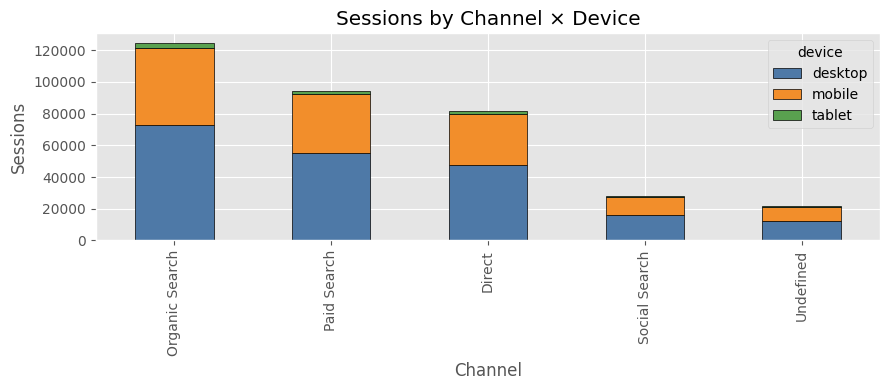

In [ ]:
# pivot_plot = pivot.drop(index='Total', errors='ignore').drop(columns='Total')
colors = ['#4e79a7', '#f28e2b', '#59a14f']
pivot_plot.plot(kind='bar', stacked=True, figsize=(9,4), edgecolor='black', color = colors)
plt.title('Sessions by Channel × Device')
plt.ylabel('Sessions'); plt.xlabel('Channel')
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout(); plt.show()

Organic Search =124k сесій(35,6% від усіх сесій), Paid Search =94k(27%), Direct =81k(23,3%); desktop стабільно дає найбільшу частку трафіку в кожному каналі, що варто врахувати при розподілі бюджетів.

Далі створимо зведену таблицю, яка показує загальні продажі за категоріями товарів (топ-10 категорій) у різних країнах (топ-5 країн)

In [ ]:
data = df[['country', 'category', 'price']].dropna()

country_sales = (data.groupby('country', as_index=False)['price'].sum()
                 .sort_values('price', ascending=False).head(5))
top_countries = country_sales['country'].tolist()


category_sales = (data.groupby('category', as_index=False)['price'].sum()
                  .sort_values('price', ascending=False).head(10))
top_categories = category_sales['category'].tolist()

# фільтруємо тільки ці країни і категорії
data_top = data[data['country'].isin(top_countries) & data['category'].isin(top_categories)]

pivot_country_category_top = pd.pivot_table(
    data_top,
    index='category',
    columns='country',
    values='price',
    aggfunc='sum',
    fill_value=0,
     observed=True
)

pivot_country_category_top['Total'] = pivot_country_category_top.sum(axis=1)
pivot_country_category_top = pivot_country_category_top.sort_values('Total', ascending=False).drop(columns='Total')

pivot_country_category_top

/tmp/ipython-input-1212155216.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipython-input-1212155216.py:8: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



country,Canada,France,India,United Kingdom,United States
category,,,,,
Sofas & armchairs,692427.5,187735.0,788430.0,234812.0,3707144.5
Chairs,417740.8,134029.4,544309.2,188519.4,2619773.8
Beds,354772.0,116414.0,358319.5,133816.0,2213058.0
Bookcases & shelving units,278981.9,73830.0,364507.4,113987.6,1567606.9
Cabinets & cupboards,181802.0,59101.5,191888.0,71684.5,994545.5
Outdoor furniture,185322.8,40486.4,162289.4,57002.4,929245.2
Tables & desks,132678.0,42299.0,186157.5,49374.0,777865.0
Chests of drawers & drawer units,71952.0,21544.5,73111.0,36784.0,382388.0
Bar furniture,51724.0,11199.0,57657.0,22103.0,330805.0


In [ ]:
tmp = pivot_country_category_top.copy()
if 'Total' in tmp.index:
    tmp = tmp.drop('Total')

col_totals = tmp.sum(axis=0)

pivot_pct_col = (tmp / col_totals) * 100

pivot_pct_col = pivot_pct_col.round(1)

pivot_pct_col

country,Canada,France,India,United Kingdom,United States
category,,,,,
Sofas & armchairs,28.9,26.8,28.5,25.5,27.0
Chairs,17.4,19.1,19.7,20.5,19.1
Beds,14.8,16.6,13.0,14.5,16.1
Bookcases & shelving units,11.6,10.5,13.2,12.4,11.4
Cabinets & cupboards,7.6,8.4,6.9,7.8,7.2
Outdoor furniture,7.7,5.8,5.9,6.2,6.8
Tables & desks,5.5,6.0,6.7,5.4,5.7
Chests of drawers & drawer units,3.0,3.1,2.6,4.0,2.8
Bar furniture,2.2,1.6,2.1,2.4,2.4


Таблиця показує, яку частку (%) від продажів у країні займає кожна категорія.
Дві категорії — Sofas & armchairs (26–29%) і Chairs (17–21%) — дають разом майже половину всієї виручки в кожній з ТОП-5 країн. Далі — Beds (13–16%) і Bookcases & shelving units (10–13%). Решта категорій — по 2–8% кожна.
Локальні відхилення:
США: трохи вищий внесок Beds (16%)
Велика Британія: відносно вищі Bookcases (12%) і Chests of drawers (4%), що вказує на попит на зберігання; варто просувати системи організації простору.
Індія: помітно вищі Bookcases (13%) і Tables & desks (6–7%),що може означати тенденцію до «домашнього офісу/навчання»; можна спробувати продаж пакетів «стіл+стелаж+крісло».
Канада: найвища частка Sofas (29%) і непоганий Outdoor (7–8%), можна спробувати сезонні промо на вулицю влітку.
Франція: сильні Chairs і Beds; Outdoor слабший → тестувати пропозиції для спальні, а для outdoor — вузькі, дизайн-орієнтовані лінійки.  
Недовикористані ніші: Children’s furniture та Bar furniture всюди <3% - або це свідомо нішеві категорії, або є шанс виростити їх таргетованими кампаніями (спробувати подарункові періоди).


# Statistical analysis of interrelationships

Тепер перевіримо кількість сесій та загальні продажі за кожну дату. Створимо візуалізацію, щоб побачити взаємозв’язок між цими метриками. Далі знайдемо відповідний коефіцієнт кореляції та проаналізуємо його статистичну значущість.

In [ ]:
grouped_by_date = (
    df.groupby('session_date', as_index=False)
      .agg(Total_sales=('price', 'sum'),
           sessions=('session_id', 'nunique'))
      .sort_values('session_date')
)
grouped_by_date

,session_date,Total_sales,sessions
0,2020-11-01,244292.5,2576
1,2020-11-02,355506.8,3599
2,2020-11-03,498979.6,5173
3,2020-11-04,339187.1,4184
4,2020-11-05,391276.6,3743
...,...,...,...
87,2021-01-27,286340.7,4435
88,2021-01-28,0.0,4112
89,2021-01-29,0.0,3700
90,2021-01-30,0.0,2845


In [ ]:
number_of_sessions = grouped_by_date["sessions"].tolist()
revenue = grouped_by_date["Total_sales"].tolist()

# Normaltest
_, p_value_normaltest_number_of_sessions = normaltest(number_of_sessions)
_, p_value_normaltest_revenue = normaltest(revenue)

# Shapiro-Wilk test
_, p_value_shapiro_number_of_sessions = shapiro(number_of_sessions)
_, p_value_shapiro_revenue = shapiro(revenue)

print(f"Normaltest for number of sessions p-value: {p_value_normaltest_number_of_sessions}")
print(f"Normaltest for revenue p-value: {p_value_normaltest_revenue}")

print(f"Shapiro-Wilk for number of sessions p-value: {p_value_shapiro_number_of_sessions}")
print(f"Shapiro-Wilk for revenue p-value: {p_value_shapiro_revenue}")

Normaltest for number of sessions p-value: 0.008655428822366544
Normaltest for revenue p-value: 0.021085752302202193
Shapiro-Wilk for number of sessions p-value: 0.026201156314308208
Shapiro-Wilk for revenue p-value: 0.0017206798751357067


Висновок по тестам на нормальність розподілу: І D’Agostino/Pearson normaltest, і Shapiro–Wilk дали дуже малі p-value як для Number of sessions, так і для Total sales.
Це означає, що по днях обидві змінні не розподілені нормально.
Що з цього випливає:
Для оцінки зв’язку краще спиратися на рангову кореляцію Спірмена.

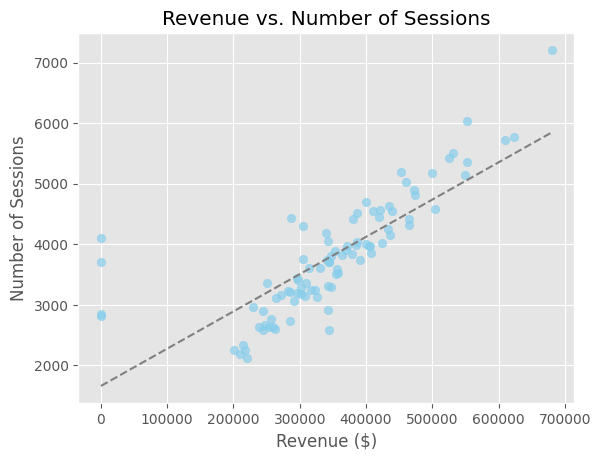

In [ ]:
plt.scatter(revenue, number_of_sessions, color="skyblue", alpha=0.7)

plt.title("Revenue vs. Number of Sessions")
plt.xlabel("Revenue ($)")
plt.ylabel("Number of Sessions")

z = np.polyfit(revenue, number_of_sessions, 1)
x_line = np.linspace(min(revenue), max(revenue), 100)
plt.plot(x_line, np.polyval(z, x_line), '--', color='gray')

plt.show()

In [ ]:
print( f"Test statistic and p-value: {spearmanr(revenue, number_of_sessions)}")

Test statistic and p-value: SignificanceResult(statistic=np.float64(0.865306217456368), pvalue=np.float64(9.755923586156684e-29))


На діаграмі розсіювання видно чіткий висхідний тренд: чим більше сесій, тим вища виручка.
Спірмен: ρ = 0.865, p-value значно меншу за 0.05 — це дуже сильна позитивна монотонна кореляція, статистично значуща. Тобто дні з більшою кількістю сесій майже завжди мають більші продажі.

Водночас є кілька відхилень (аутлаєрів): дні, де сесій багато, а виручка нижча за очікуване - ймовірні проблеми з конверсією/кошиком/оплатами або неякісним трафіком. Їх і передивимось далі.


In [ ]:
x = grouped_by_date['sessions'].values
y = grouped_by_date['Total_sales'].values

a, b = np.polyfit(x, y, 1)
y_hat = a*x + b
resid = y - y_hat

thr = 3 * resid.std(ddof=1)
mask = (np.abs(resid) > thr)

outliers_resid = grouped_by_date.loc[mask, ['session_date','sessions','Total_sales']]
outliers_resid['residual'] = resid[mask]
print(outliers_resid.sort_values('residual'))

   session_date  sessions  Total_sales       residual
88   2021-01-28      4112          0.0 -379291.206970
89   2021-01-29      3700          0.0 -337415.596003
90   2021-01-30      2845          0.0 -250513.539264
91   2021-01-31      2812          0.0 -247159.424794


Треба додатково дослідити дні, з 28 до 31 - де були сесії, але не було жодної покупки. Можливо, були технічні роботи на сайті, або інформація про покупки не потрапила в надану базу.

Далі проаналізуємо продажі за кожну дату зареєстрованих та незареєстрованих користувачів:  
* Створюємо відповідні вибірки, аналіз розподілів даних в обох вибірках.  
* Використовуємо відповідний статистичний тест для порівняння вибірок.


In [ ]:
df_registered = df[df['user_id'].notna()].copy()
df_guests = df[df['user_id'].isna()].copy()

daily_sales_registered = (df_registered.groupby(['session_date'])['price']
                    .sum()
                    .reset_index()
                    .rename(columns={'price':'sales_accounts'}))

daily_sales_guests = (df_guests.groupby(['session_date'])['price']
                    .sum()
                    .reset_index()
                    .rename(columns={'price':'sales_guests'}))
#Використала inner merge через те, що по обох типах користувачів в базі немає продаж за останні 4 дні, залишок 87 днів нам відобразило вірно при inner.
merged_sales_daily = pd.merge(daily_sales_registered, daily_sales_guests, on='session_date')
merged_sales_daily

,session_date,sales_accounts,sales_guests
0,2020-11-01,21547.0,222745.5
1,2020-11-02,44956.8,310550.0
2,2020-11-03,29150.5,469829.1
3,2020-11-04,20982.2,318204.9
4,2020-11-05,25334.6,365942.0
...,...,...,...
83,2021-01-23,16117.0,274488.5
84,2021-01-24,20914.0,222904.4
85,2021-01-25,34163.8,270925.5
86,2021-01-26,27213.6,344843.7


In [ ]:
sales_registered = merged_sales_daily["sales_accounts"].tolist()
sales_guests = merged_sales_daily["sales_guests"].tolist()

In [ ]:
_, p_value_normaltest_sales_registered = normaltest(sales_registered)
_, p_value_normaltest_sales_guests = normaltest(sales_guests)

# Shapiro-Wilk test
_, p_value_shapiro_sales_registered = shapiro(sales_registered)
_, p_value_shapiro_sales_guests = shapiro(sales_guests)

print(f"Normaltest for sales for registered users p-value: {p_value_normaltest_sales_registered}")
print(f"Normaltest for sales_guests p-value: {p_value_normaltest_sales_guests}")

print(f"Shapiro-Wilk for sales for registered users p-value: {p_value_shapiro_sales_registered}")
print(f"Shapiro-Wilk for sales_guests p-value: {p_value_shapiro_sales_guests}")

Normaltest for sales for registered users p-value: 0.010929121653065912
Normaltest for sales_guests p-value: 0.005566190512660351
Shapiro-Wilk for sales for registered users p-value: 0.007295139880540744
Shapiro-Wilk for sales_guests p-value: 0.0026183359245325936


Висновок щодо нормальності:  
І для зареєстрованих (normaltest p≈0.0109; Shapiro p≈0.0073), і для гістьових користувачів (normaltest p≈0.0056; Shapiro p≈0.0026) p-value < 0.05.  
Отже, за обома тестами ми відхиляємо H0 про нормальний розподіл денних продажів у кожній вибірці.


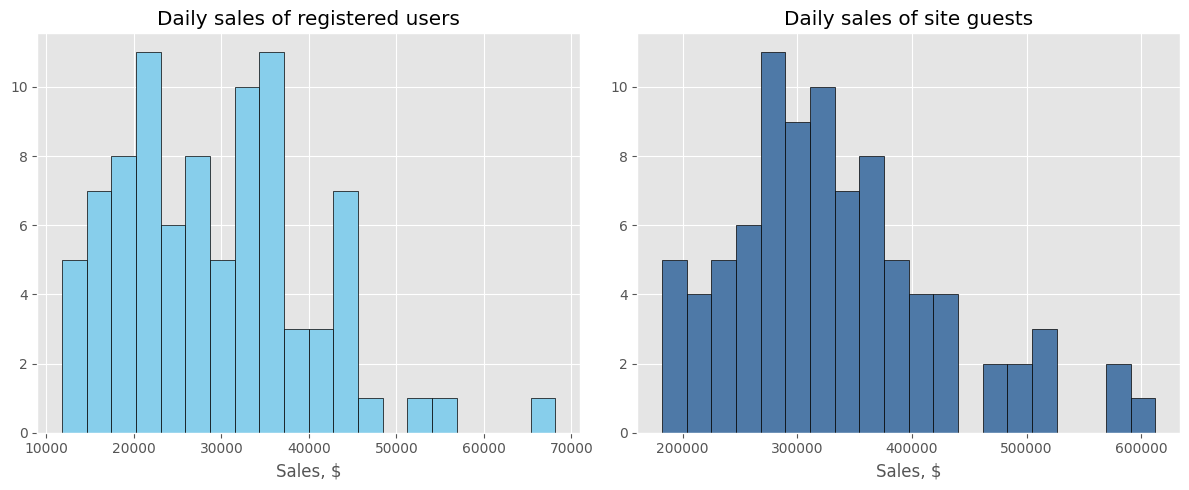

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(sales_registered, bins=20, color="skyblue", edgecolor="black")
plt.title("Daily sales of registered users")
plt.xlabel("Sales, $")

plt.subplot(1, 2, 2)
plt.hist(sales_guests, bins=20, color='#4e79a7', edgecolor="black")
plt.title("Daily sales of site guests")
plt.xlabel("Sales, $")

plt.tight_layout()
plt.show()

Гості (unregistered):
Денна виручка тримається десь у 250–400 тис. $ зі скосом вправо до ~600 тис. $.
Розкид великий: часто трапляються дні-піки. Це дає сильну асиметрію й аутлаєри.
Зареєстровані (registered):
Базовий рівень у ~15–45 тис. $ на день, зрідка до 50–70 тис. $.
Розкид значно менший, розподіл теж правоскошений, але без таких сильних викидів.
Для порівняння цих груп використаємо непараметричний тест Манна-Вітні.


In [ ]:
stat, p_value = mannwhitneyu(sales_registered, sales_guests)

print(f"U-statistic: {stat}")
print(f"P-value: {p_value}")

# Interpretation
if p_value < 0.05:
    print("There is a significant difference in sales to registered users and to guests.")
else:
    print("There is no significant difference in sales to registered users and to guests.")

U-statistic: 0.0
P-value: 2.2159276950123465e-30
There is a significant difference in sales to registered users and to guests.


Бачимо, що різниця між між продажами зареєстрованим та незареєстрованим користувачає є статистично значущою.
Використано функцію mannwhitneyu з бібліотеки scipy.stats у Python. Значення p-value значно менше 0.05, це вказує на значущу різницю у продажах цим двом типам користувачів.

/tmp/ipython-input-3356387745.py:2: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.



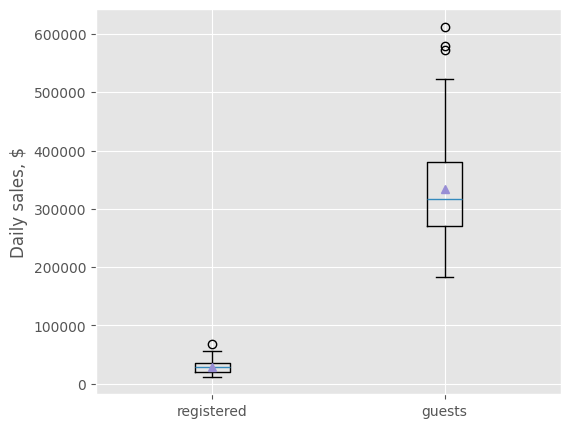

In [ ]:
plt.figure(figsize=(6,5))
plt.boxplot([sales_registered, sales_guests], labels=["registered","guests"], showmeans=True)
plt.ylabel("Daily sales, $")
plt.show()

In [ ]:
def quick_stats(x):
    x = np.array(x, dtype=float)
    x = x[~np.isnan(x)]                     # прибрати NaN, якщо раптом є
    mean   = np.mean(x)
    median = np.median(x)
    std    = np.std(x, ddof=0)             # для z-score краще ddof=0 (популяційне)
    q1, q2, q3 = np.percentile(x, [25, 50, 75])
    return {
        "mean": mean, "median": median, "std": std,
        "q1": q1, "q2": q2, "q3": q3
    }

reg_stats   = quick_stats(sales_registered)
guest_stats = quick_stats(sales_guests)

print("REGISTERED:", reg_stats)
print("GUESTS    :", guest_stats)

REGISTERED: {'mean': np.float64(29346.801136363636), 'median': np.float64(28048.0), 'std': np.float64(10704.109548158407), 'q1': np.float64(20717.375), 'q2': np.float64(28048.0), 'q3': np.float64(35774.7)}
GUESTS    : {'mean': np.float64(333968.325), 'median': np.float64(316724.25), 'std': np.float64(92380.79986904285), 'q1': np.float64(270485.5), 'q2': np.float64(316724.25), 'q3': np.float64(379948.475)}


In [ ]:
def iqr_outliers(x):
    x = np.array(x, dtype=float)
    q1, q3 = np.percentile(x, [25, 75])
    iqr = q3 - q1
    low  = q1 - 1.5 * iqr
    high = q3 + 1.5 * iqr
    idx = np.where((x < low) | (x > high))[0]
    return idx, (low, high), (q1, q3, iqr)

# REGISTERED
reg_i_idx, reg_bounds, reg_iqr = iqr_outliers(sales_registered)
print("IQR bounds (REGISTERED):", reg_bounds, " | Q1,Q3,IQR:", reg_iqr)
print("Outlier idx (REGISTERED):", reg_i_idx.tolist())
print(merged_sales_daily.iloc[reg_i_idx][["session_date","sales_accounts"]])

# GUESTS
gst_i_idx, gst_bounds, gst_iqr = iqr_outliers(sales_guests)
print("\nIQR bounds (GUESTS):", gst_bounds, " | Q1,Q3,IQR:", gst_iqr)
print("Outlier idx (GUESTS):", gst_i_idx.tolist())
print(merged_sales_daily.iloc[gst_i_idx][["session_date","sales_guests"]])

IQR bounds (REGISTERED): (np.float64(-1868.6124999999956), np.float64(58360.68749999999))  | Q1,Q3,IQR: (np.float64(20717.375), np.float64(35774.7), np.float64(15057.324999999997))
Outlier idx (REGISTERED): [37]
   session_date  sales_accounts
37   2020-12-08         68151.1

IQR bounds (GUESTS): (np.float64(106291.03750000003), np.float64(544142.9375))  | Q1,Q3,IQR: (np.float64(270485.5), np.float64(379948.475), np.float64(109462.97499999998))
Outlier idx (GUESTS): [37, 39, 66]
   session_date  sales_guests
37   2020-12-08      612358.4
39   2020-12-10      571790.6
66   2021-01-06      579180.8


**Висновки з boxplot і описової статистики**.
Рівень денних продажів:  
1) Медіана по guests ≈ 317 тис. дол; це приблизно у 11 разів вище, ніж по registered ≈ 28 тис. дол.  
2) Основний грошовий потік зараз формують незареєстровані користувачі; зареєстровані дають менший, але стабільніший внесок.

Варіативність (IQR):  
* Guests: широкий IQR ≈ 279–380 тис. дол — сильні коливання з піками.
* Registered: компактний IQR ≈ 20–36 тис. дол — рівніша, передбачуваніша динаміка.

Викиди (outliers):  
* Guests: кілька яскравих викидів ≈ 612 тис. дол, 579 тис. дол, 571 тис. дол — це пікові дні (переважно перед святами/на початку січня).
* Registered: один помітний викид ≈ 68 тис. дол — масштаб значно менший.

Середнє:
* для guests помітно вище за медіану (правий «хвіст» підтягує mean вгору);
* для registered середнє близьке до медіани — розподіл спокійніший.

Для компанії це:  
Гроші зараз — у guests: вони дають і базу, і пікові каси, але компанія не має з ними зв'язку, не може надсилати повідомлення для підігріву та інші розсилки.
Registered — «якір стабільності»: менші суми щодня, зате рівно і прогнозовано.

Рекомендації:
* Конвертація гостей в акаунти — без втрати швидкості чекауту: після оплати — one-click створення акаунта (magic-link / соцлогін), коротке пояснення вигод (статус замовлення, гарантія, бали).
* Активація registered — персональні офери, тригери на повторну покупку, проста програма лояльності.
* Підготовка до піків guests — планувати запаси/доставку/підтримку на передсвяткові тижні; тестувати промо, що підвищують середній чек саме в ці дні.
* Моніторинг викидів — фіксувати дати/канали пікових днів і масштабувати успішні механіки (креатив, канал, офер).

Вивантажуємо дані для підготовки дашборду в Tableau.

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

# Changing work folder
%cd /content/drive/MyDrive/Pandas2

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Pandas2


In [ ]:
df.to_csv("portfolio_data.csv", index=False)